# Introduction

In this work, a multi-class classification supervised learning model has been built to predict product category (prodcat1) a customer is likely to order. This notebook can be broken down into the following sections:
1. [Exploratory data analysis](#Exploratory-Data-Analysis): handle missing values; gain insights; propose customer segmentation idea
2. [Feature engineering](#Feature-Engineering) and [feature selection](#Feature-Selection): compute aggregated features; visualize features correlation; rank feature importance and select features with most predictive power.
3. [Data preparation and sampling](#Data-Preparation): randomly sample a smaller dataset to speed up training and test process; prepare the data for traditional ML inputs and neural network inputs.
4. [Modeling](#Modeling): random forest model; GBDT; neural network with embedding layer
5. [Summary](#Summary): model comparison and improvements to be done.

# Libraries

In [1392]:
import datetime as dt
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from keras import Sequential,Model,optimizers,metrics,callbacks
from keras.layers import Embedding, Reshape, Dense,Activation,Concatenate,Input,Dot,Flatten,BatchNormalization,Dropout
from keras.utils.np_utils import to_categorical
from math import ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize,StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from time import time

# Utils

In [1400]:
#function to get the feature representing order number of specific prodcat1 by specific customer in the past n days before the observation
def aggregate_feature_count_cat1(df,custno, cat1,endtime,days):
    starttime = endtime-pd.to_timedelta(str(days)+'days')
    slot_df = df.loc[starttime:endtime]
    return len(slot_df[(slot_df.prodcat1==cat1) & (slot_df.custno==custno)])

#function to get the feature representing most frequently ordered prodcat1 by specific customer in the past n days before the observation
def aggregate_feature_max_cat1(df,custno,endtime,days):
    starttime = endtime-pd.to_timedelta(str(days)+'days')
    slot_df = df.loc[starttime:endtime]
    if len(slot_df[(slot_df.custno==custno)])!=0:
        return slot_df[(slot_df.custno==custno)].prodcat1.value_counts().idxmax()  
    else:
        return 0
    
#function to get the feature representing most frequently ordered prodcat2 by specific customer in the past n days before the observation
def aggregate_feature_max_cat2(df,custno,endtime,days):
    starttime = endtime-pd.to_timedelta(str(days)+'days')
    slot_df = df.loc[starttime:endtime]
    return slot_df[(slot_df.custno==custno)].prodcat2.value_counts().idxmax() if len(slot_df[(slot_df.custno==custno)])!=0 else 0

#function to get the feature representing mean revenue of ordered product by specific customer in the past n days before the observation
def aggregate_feature_mean_rev(df,custno,endtime,days):
    starttime = endtime-pd.to_timedelta(str(days)+'days')
    slot_df = df.loc[starttime:endtime]
    return slot_df[(slot_df.custno==custno)].revenue.sum()/len(slot_df[(slot_df.custno==custno)])

#function to get the feature representing most frequent event in the past n days before the observation
def aggregate_feature_max_event(df,custno,endtime,days):
    starttime = endtime-pd.to_timedelta(str(days)+'days')
    slot_df = df.loc[starttime:endtime]
    if len(slot_df[(slot_df.custno==custno)])!=0:
        return slot_df[(slot_df.custno==custno)].event.value_counts().idxmax()  
    else:
        return 0

#fucntion to plot the loss and accuracy over epoch in the training of neural network
def training_plot():
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    fig,(axis1,axis2)= plt.subplots(1,2,figsize=(15,5))
    fig.figsize= [10,10]
    axis1.set_title('Loss curve')
    axis1.set_xlabel("Epochs")
    axis1.set_ylabel("Loss")
    axis1.plot( loss  )
    axis1.plot(val_loss)
    axis2.set_title('accuracy curve')
    axis2.set_xlabel("Epochs")
    axis2.set_ylabel("accuracy")
    axis2.plot( accuracy  )
    axis2.plot(val_accuracy)
    
#function to plot feature importance
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Exploratory Data Analysis

In this section, two dataset 'online.csv' and 'order.csv' were loaded. Missing values in the dataset were handled properly. After analysis, some insights of product category and customers were gained. Then customer segmentation is conducted based on customers' behavior.

In [1401]:
#load two dataset
online_df = pd.read_csv('data/online.csv')
order_df = pd.read_csv('data/order.csv')

In [1402]:
online_df.head()

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [1403]:
order_df.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


## 1. Handle missing values 

In [1412]:
#Handle missing value in 'prodcat2'
n = len(order_df)
print ('In order_df, missing value percentatge are as following: \n{}'.format(order_df.isna().sum()/n))

In order_df, missing value percentatge are as following: 
custno       0.000000
ordno        0.000000
orderdate    0.000000
prodcat2     0.006924
prodcat1     0.000000
revenue      0.000000
dtype: float64


In [1413]:
#remove the NAN value observation from order_df
order_df = order_df[order_df.prodcat2.isna()==False]

In [1414]:
#Handle missing value in 'event1'
print ('In online_df, missing value percentatge are as following: \n{}'.format(online_df.isna().sum()/len(online_df)))

In online_df, missing value percentatge are as following: 
session     0.00000
visitor     0.00000
dt          0.00000
custno      0.00000
category    0.00000
event1      0.82726
event2      0.00000
dtype: float64


In [1415]:
#remove feature 'event1' from online_df
online_df.drop('event1',axis=1,inplace=True)

In [1416]:
#rename the columns in online_df
online_df.rename(columns = {'category':'prodcat1', 'dt':'onlinedate','event2':'event'}, inplace = True)

In [1419]:
order_df

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
1823,9753,13520,2016-05-21 18:02:13,256.0,3,55.65
1824,7720,123109,2016-01-24 09:04:12,256.0,3,126.07
1825,4675,129584,2016-02-29 20:27:33,256.0,3,79.76
1826,7499,152478,2016-04-13 20:40:03,256.0,3,25.01
1827,43402,77848,2016-06-23 05:44:59,256.0,3,55.16
...,...,...,...,...,...,...
263273,7443,99084,2018-09-23 16:02:08,253.0,1,6.67
263274,6693,8660,2017-06-08 21:37:34,253.0,1,122.98
263275,22914,36144,2017-05-12 14:07:18,253.0,1,143.34
263276,36088,62664,2018-03-11 20:19:18,253.0,1,49.75


In [1420]:
online_df

,session,visitor,onlinedate,custno,prodcat1,event
0,419542,140970,2016-09-16 05:03:23,3840,1,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,1
3,880408,90673,2017-10-28 13:42:38,39168,1,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,1
...,...,...,...,...,...,...
954769,1136918,61351,2017-01-10 18:16:01,25087,3,10
954770,2400378,226006,2017-07-14 13:46:19,27135,3,10
954771,2014765,210713,2017-08-19 14:47:11,35583,3,10
954772,2963482,144530,2016-01-15 15:55:51,41215,3,10


## 2. Insights

In [1421]:
#Insight into category
print ('There are 6 categories in order_df: {}; but only 3 categories {} were visited online in online_df'\
       .format(order_df.prodcat1.unique(),online_df.prodcat1.unique()))

There are 6 categories in order_df: [3 2 7 4 1 5]; but only 3 categories [1 2 3] were visited online in online_df


In [1422]:
#Insight into customer
print ('Assuming customer id starts from 1, there are totally {} customers on the websites.'.format(max(order_df.custno)))

Assuming customer id starts from 1, there are totally 71427 customers on the websites.


In [1423]:
count=0
order_cust = set(order_df.custno)
for i in  range(1,71428):
    if i not in order_cust:
        count+=1
print ('There are {} customers in the dataset have no order history in the time period btw {} to {}'.\
       format(count,order_df.orderdate.values.min(), order_df.orderdate.values.max()))

There are 2813 customers in the dataset have no order history in the time period btw 2016-01-01 05:05:14 to 2019-01-02 23:54:58


In [1424]:
count=0
online_cust = set(online_df.custno)
for i in  range(1,71428):
    if i not in online_cust:
        count+=1
print ('There are {} customers in the dataset have no online browsing history in the time period btw {} to {}'.\
       format(count,online_df.onlinedate.values.min(), online_df.onlinedate.values.max()))

There are 13843 customers in the dataset have no online browsing history in the time period btw 2016-01-01 00:00:08 to 2017-12-31 23:58:05


## 3. Customer Segmentation

In [1426]:
#convert the time string to datetime
order_df.orderdate = pd.to_datetime(order_df.orderdate)
online_df.onlinedate = pd.to_datetime(online_df.onlinedate)

In [1429]:
#Get the most recent order time
max_datetime = order_df.orderdate.max()
NOW = max_datetime+pd.to_timedelta('1days')
print (NOW)

2019-01-03 23:54:58


In [1430]:
#create RFM (recency, frequency, monetary_value) table
rfmTable = order_df.groupby('custno').agg({'orderdate': lambda x: (NOW - x.max()).days, 'ordno': lambda x: len(x), 'revenue': lambda x: x.sum()})
rfmTable['orderdate'] = rfmTable['orderdate'].astype(int)
rfmTable.rename(columns={'orderdate': 'recency', 
                         'ordno': 'frequency', 
                         'revenue': 'monetary_value'}, inplace=True)

In [1431]:
rfmTable.head()

,recency,frequency,monetary_value
custno,,,
6,340,5,306.46
7,983,6,665.35
8,16,80,6700.94
9,21,136,10362.70
10,634,2,131.43


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19b21c6a0>,
      dtype=object)

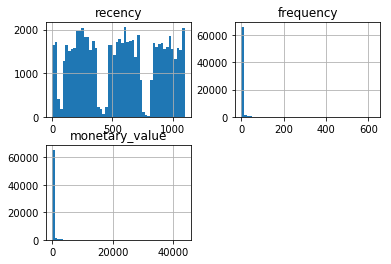

In [1432]:
#check the data skewness
rfmTable.hist(bins=50)

In [1434]:
rfm_df=rfmTable.copy()

In [1435]:
#use boxcox transformation to reduce the data skewness
rfm_df["recency"] = stats.boxcox(rfmTable["recency"])[0]
rfm_df["frequency"] = stats.boxcox(rfmTable['frequency'])[0]
rfm_df["monetary_value"] = stats.boxcox(rfmTable["monetary_value"])[0]
#normalize the data
scaler = StandardScaler()
normalized_rfm_df = scaler.fit_transform(rfm_df)

In [1436]:
normalized_rfm_df

array([[-0.56125751,  1.28971172,  0.73359464],
       [ 1.22360899,  1.42823485,  1.44672355],
       [-2.04025408,  2.27661885,  3.72913712],
       ...,
       [ 0.20871656, -1.13037496, -0.8440803 ],
       [ 1.25473733, -1.13037496, -1.15917043],
       [-2.20105598, -1.13037496,  0.0443234 ]])

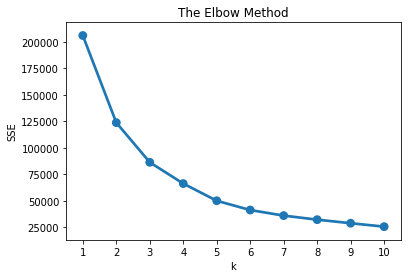

In [1437]:
#KMeans clustering 
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_rfm_df)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [1438]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(normalized_rfm_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [1439]:
rfmTable['clusterid']=model.labels_

In [1440]:
rfmTable

,recency,frequency,monetary_value,clusterid
custno,,,,
6,340,5,306.46,1
7,983,6,665.35,0
8,16,80,6700.94,1
9,21,136,10362.70,1
10,634,2,131.43,0
...,...,...,...,...
71421,212,1,71.94,2
71423,318,1,134.13,2
71424,591,1,49.63,2


In [1441]:
#Compare the clusters
rfmTable.groupby('clusterid').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary_value':'sum'}).round(2)

,recency,frequency,monetary_value
clusterid,,,
0,770.02,2.70,4794802.90
1,197.37,9.55,12797308.09
2,606.61,1.03,2004775.92


By comparison, 
1. cluster1 is most frequent, spend more and buy product recently--> loyal customer
2. cluster0 is less frequent, spend less and buy product long time ago --> medium activity customer
3. cluster2 is lowest frequent, spend lowest and buy product long time ago --> lowest activity customer


In [1442]:
#cluster the order_df by add clusterid to each observation
clustered_order_df = order_df.join(rfmTable[['clusterid']],on='custno')
clustered_order_df

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,clusterid
1823,9753,13520,2016-05-21 18:02:13,256.0,3,55.65,0
1824,7720,123109,2016-01-24 09:04:12,256.0,3,126.07,1
1825,4675,129584,2016-02-29 20:27:33,256.0,3,79.76,1
1826,7499,152478,2016-04-13 20:40:03,256.0,3,25.01,1
1827,43402,77848,2016-06-23 05:44:59,256.0,3,55.16,2
...,...,...,...,...,...,...,...
263273,7443,99084,2018-09-23 16:02:08,253.0,1,6.67,1
263274,6693,8660,2017-06-08 21:37:34,253.0,1,122.98,1
263275,22914,36144,2017-05-12 14:07:18,253.0,1,143.34,0
263276,36088,62664,2018-03-11 20:19:18,253.0,1,49.75,1


In [1443]:
#split the dataset into three segments by customer clusters
cluster0_order_df = clustered_order_df[clustered_order_df.clusterid==0]
cluster1_order_df = clustered_order_df[clustered_order_df.clusterid==1]
cluster2_order_df = clustered_order_df[clustered_order_df.clusterid==2]

In the following sections, let's take cluster1 as example and dive into the feature engineering and modeling.

# Feature Eningeering

In this section, aggregated features will be computed. The followings are the definitions for all the new features:
1. 'past200days_count_cat1': For current observation, total count of the same customer order the same prodcat1 in the past 90 days.
2. 'past7days_max_cat1': For current observation, most frequent ordered prodcat1 by the same customer in the past 7 days.
3. 'past7days_max_cat2': For current observation, most frequent ordered prodcat2 by the same customer in the past 7 days.
4. 'past7days_mean_revenue': For current observation, mean value of revenue of product ordered by the same customer in the past 7 days.
5. 'past7days_max_browse_cat1': For current observation, most frequent browsed prodcat1 by the same customer in the past 7 days.
6. 'past7days_max_browse_event': For current observation, most frequent browsed event by the same customer in the past 7 days.

In [1445]:
#pick cluster1 (loyal customer) as an example
seg_order_df = cluster1_order_df

In [1446]:
#Set the datetime as index and sort by index
temp_order_df = seg_order_df.set_index('orderdate').sort_index()
temp_online_df = online_df.set_index('onlinedate').sort_index()

In [1448]:
temp_order_df

,custno,ordno,prodcat2,prodcat1,revenue,clusterid
orderdate,,,,,,
2016-01-01 06:50:12,7883,86903,2.0,2,70.34,1
2016-01-01 06:50:12,7883,86903,5.0,2,54.46,1
2016-01-01 06:58:35,1553,143018,38.0,5,138.43,1
2016-01-01 07:48:27,1553,121976,9.0,3,130.45,1
2016-01-01 07:48:27,1553,121976,3.0,2,98.73,1
...,...,...,...,...,...,...
2019-01-02 23:16:38,30586,51674,9.0,3,4.04,1
2019-01-02 23:16:38,30586,51674,3.0,2,111.93,1
2019-01-02 23:16:38,30586,51674,16.0,4,44.60,1


In [1450]:
#Add new feature 'past200days_count_cat1' (Warning: This step is time consuming!)
for i in [200]:
    temp_order_df['past'+str(i)+'days_count_cat1'] = temp_order_df[['custno','prodcat1']]\
    .apply(lambda x: aggregate_feature_count_cat1(temp_order_df,x[0], x[1],x.name,i),axis=1)

In [1451]:
#Add other new aggregated features (Warning: This step is most time consuming part!)
for i in [7]:
    #Add new feature 'past7days_max_cat1', 'past7days_max_cat2'
    temp_order_df['past'+str(i)+'days_max_cat1'] = temp_order_df[['custno']].apply(lambda x: aggregate_feature_max_cat1(temp_order_df,x[0],x.name,i),axis=1)
    temp_order_df['past'+str(i)+'days_max_cat2'] = temp_order_df[['custno']].apply(lambda x: aggregate_feature_max_cat2(temp_order_df,x[0],x.name,i),axis=1)
    #add aggreated feature 'past7days_mean_revenue'
    temp_order_df['past'+str(i)+'days_mean_revenue'] = temp_order_df[['custno']].apply(lambda x: aggregate_feature_mean_rev(temp_order_df,x[0],x.name,i),axis=1)
    #add aggregated features 'past7days_max_browse_cat1'
    temp_order_df['past'+str(i)+'days_max_browse_cat1'] = temp_order_df[['custno']].apply(lambda x: aggregate_feature_max_cat1(temp_online_df,x[0],x.name,i),axis=1)
    #add aggregated features 'past7days_max_browse_event'
    temp_order_df['past'+str(i)+'days_max_browse_event'] = temp_order_df[['custno']].apply(lambda x: aggregate_feature_max_event(temp_online_df,x[0],x.name,i),axis=1)

In [1452]:
temp_order_df.head()

,custno,ordno,prodcat2,prodcat1,revenue,clusterid,past200days_count_cat1,past7days_max_cat1,past7days_max_cat2,past7days_mean_revenue,past7days_max_browse_cat1,past7days_max_browse_event
orderdate,,,,,,,,,,,,
2016-01-01 06:50:12,7883,86903,2.0,2,70.34,1,2,2,5.0,62.400000,0,0
2016-01-01 06:50:12,7883,86903,5.0,2,54.46,1,2,2,5.0,62.400000,0,0
2016-01-01 06:58:35,1553,143018,38.0,5,138.43,1,1,5,38.0,138.430000,0,0
2016-01-01 07:48:27,1553,121976,9.0,3,130.45,1,1,3,3.0,122.536667,0,0
2016-01-01 07:48:27,1553,121976,3.0,2,98.73,1,1,3,3.0,122.536667,0,0


# Feature Selection

In this section, meaningful and predictive features are selected. Their correlations and importance are separately investigated by using corr matrix and random forest.

In [1453]:
# After feature engineering, the table has the following dimensions:
list(temp_order_df.columns)

['custno',
 'ordno',
 'prodcat2',
 'prodcat1',
 'revenue',
 'clusterid',
 'past200days_count_cat1',
 'past7days_max_cat1',
 'past7days_max_cat2',
 'past7days_mean_revenue',
 'past7days_max_browse_cat1',
 'past7days_max_browse_event']

1. 'prodcat1' will be used as label
2. At inference time, original features such as 'ordno','prodcat2','revenue' can not be known, in order to avoiding data leakage, they can not be used as inputs.
3. 'custno','past90days_count_cat1','past7days_max_cat1','past7days_max_cat2','past7days_mean_revenue', 'past7days_max_browse_cat1','past7days_max_browse_event' will be used as the features. 
4. 'clusterid' is 1 here, not predictive.

Then, let's find their correlations and rank their importance.

In [1454]:
#define feature list and label
features = ['custno','past200days_count_cat1','past7days_max_cat1','past7days_max_cat2',
            'past7days_mean_revenue', 'past7days_max_browse_cat1','past7days_max_browse_event']
label = 'prodcat1'

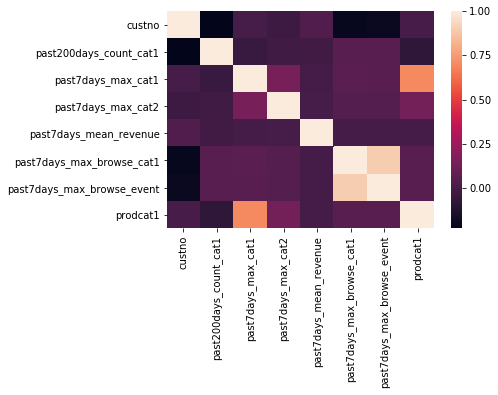

In [1455]:
#Find the correlation btw features and label by using corr matrix
sns.heatmap(temp_order_df[features+[label]].corr())

## The correlation matrix indicate that: 
1. 'past7days_max_cat1' has the strongest  correlation with 'prodcat1', which means the category of customer next order is highly dependent on the categories of orders he made in the past 7 days. There it is the most predictive feature will be used in our prediction. 
2. 'past200days_count_cat1' has the lowest correlation with 'prodcat1', which means the category of customer next order is not necessarily related to the number of same category ordered by customer in the past 200 days.  So it can be replaced with some new features in the future.
3. 'past7days_max_browse_cat1' is highly correlated with 'past7days_max_browse_event'. In order to reducing the variance in the training, it is better to use only one of them as input.

Then, let's utilize random forest to compare the importance of features. 

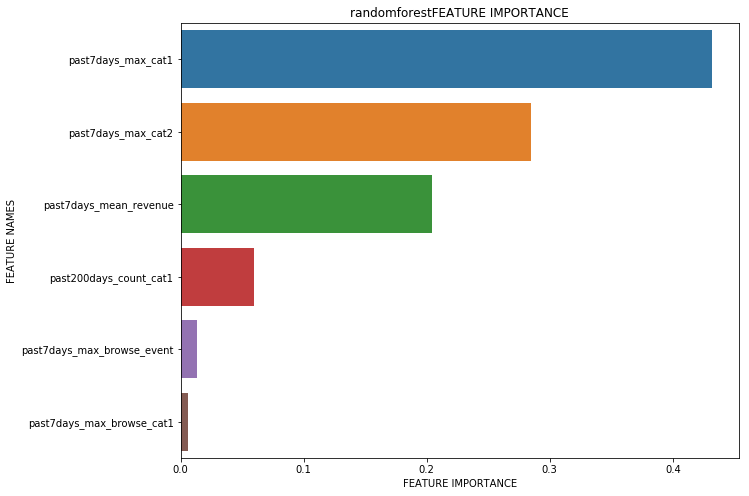

In [1456]:
#Rank the feature importance by using random forest
rfc = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
X = temp_order_df[features[1:]]
y = temp_order_df[label]
rfc.fit(X,y)
importance = rfc.feature_importances_
plot_feature_importance(importance,features[1:],'randomforest')

Conclusion:
1. No doubt 'past7days_max_cat1' has the highest importance score as expected. It contributes >40% importance.
2. 'past7days_max_cat2' and 'past7days_mean_revenue' are also important. They contributes about 50% importance.
3. 'past200days_count_cat1', 'past7days_max_browse_cat1','past7days_max_browse_event' are not as predictive as the above three features. 

# Data Preparation

In this section, a small dataset is randomly smapled from the original dataset. Then, it is splitted into train and test group. At last, separately prepare the data as inputs for traditional ML model and neural network model.

In [1457]:
#sample a small dataset from the original dataset
df=temp_order_df.sample(frac=0.1,replace=False,random_state=1)

In [1458]:
df_train,df_test = train_test_split(df,test_size=0.2, random_state=42)

In [1459]:
features

['custno',
 'past200days_count_cat1',
 'past7days_max_cat1',
 'past7days_max_cat2',
 'past7days_mean_revenue',
 'past7days_max_browse_cat1',
 'past7days_max_browse_event']

In [1460]:
label

'prodcat1'

In [1461]:
#create inputs for traditional ML model
X_train_ = np.asarray(df_train[features])
X_test_ = np.asarray(df_test[features])
y_train_ =np.asarray(df_train[label])
y_test_ =np.asarray(df_test[label])

In [1462]:
#create inputs for neural network model
X_train = [np.asarray(df_train[features[0]]),np.asarray(df_train[features[1:]])]
X_test = [np.asarray(df_test[features[0]]),np.asarray(df_test[features[1:]])]
y_train =np.asarray(pd.get_dummies(df_train[label]))
y_test =np.asarray(pd.get_dummies(df_test[label]))

# Modeling

In this section, three models are built to solve this problem: Random Forest, GBDT, Catboost and neural network. 


## 1. Random Forest

In [1463]:
rfc = RandomForestClassifier()
rfc_grid = {
    'bootstrap': [True],
    'max_depth': [80],
    'min_samples_leaf': [2],
    'min_samples_split': [12],
    'n_estimators': [200]
}
grid_search = GridSearchCV(estimator = rfc, param_grid = rfc_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_,y_train_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80], 'min_samples_leaf': [2], 'min_samples_split': [12], 'n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [1464]:
print ('After tuning, the best parameters values are:')
grid_search.best_params_

After tuning, the best parameters values are:


{'bootstrap': True,
 'max_depth': 80,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 200}

In [1465]:
print ('The best accuracy:')
grid_search.score(X_test_,y_test_)

The best accuracy:


0.8162544169611308

## 2. GBDT

In [1466]:
#gradient boost regressor
gbc = GradientBoostingClassifier()
gbc_grid = {
    "learning_rate": [0.05],
    "min_samples_split": [12],
    "min_samples_leaf": [8],
    "max_depth":[8],
    'max_features': ['auto'],
    "n_estimators":[80]
    }
grid_search = GridSearchCV(estimator = gbc, param_grid = gbc_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_,y_train_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.3s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.05], 'min_samples_split': [12], 'min_samples_leaf': [8], 'max_depth': [8], 'max_features': ['auto'], 'n_estimators': [80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [1467]:
print ('After tuning, the best parameters values are:')
grid_search.best_params_

After tuning, the best parameters values are:


{'learning_rate': 0.05,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 12,
 'n_estimators': 80}

In [1468]:
print ('The best accuracy:')
grid_search.score(X_test_,y_test_)

The best accuracy:


0.8268551236749117

## 3. Catboost 

In [1469]:
cbc = CatBoostClassifier()
cbc_grid={
    'learning_rate': [0.5, 0.1],
    'depth': [2,4],
    'l2_leaf_reg': [1]
    }
grid_search = GridSearchCV(estimator = cbc, param_grid = cbc_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_,y_train_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   30.4s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   30.6s finished


0:	learn: 1.5384527	total: 44.5ms	remaining: 44.5s
1:	learn: 1.3847986	total: 78.9ms	remaining: 39.4s
2:	learn: 1.2728352	total: 131ms	remaining: 43.5s
3:	learn: 1.1899738	total: 154ms	remaining: 38.4s
4:	learn: 1.1208531	total: 174ms	remaining: 34.7s
5:	learn: 1.0670562	total: 191ms	remaining: 31.6s
6:	learn: 1.0233279	total: 217ms	remaining: 30.8s
7:	learn: 0.9901574	total: 231ms	remaining: 28.6s
8:	learn: 0.9546072	total: 407ms	remaining: 44.9s
9:	learn: 0.9267436	total: 532ms	remaining: 52.7s
10:	learn: 0.9026431	total: 549ms	remaining: 49.3s
11:	learn: 0.8824179	total: 571ms	remaining: 47s
12:	learn: 0.8631820	total: 579ms	remaining: 43.9s
13:	learn: 0.8457578	total: 590ms	remaining: 41.5s
14:	learn: 0.8323344	total: 597ms	remaining: 39.2s
15:	learn: 0.8187955	total: 604ms	remaining: 37.2s
16:	learn: 0.8065700	total: 613ms	remaining: 35.5s
17:	learn: 0.7946789	total: 619ms	remaining: 33.8s
18:	learn: 0.7849299	total: 626ms	remaining: 32.3s
19:	learn: 0.7770532	total: 632ms	remaini

170:	learn: 0.5740570	total: 3.73s	remaining: 18.1s
171:	learn: 0.5734407	total: 3.75s	remaining: 18s
172:	learn: 0.5732103	total: 3.77s	remaining: 18s
173:	learn: 0.5729343	total: 3.79s	remaining: 18s
174:	learn: 0.5728138	total: 3.82s	remaining: 18s
175:	learn: 0.5726757	total: 3.84s	remaining: 18s
176:	learn: 0.5724439	total: 3.86s	remaining: 17.9s
177:	learn: 0.5720776	total: 3.88s	remaining: 17.9s
178:	learn: 0.5717912	total: 3.89s	remaining: 17.9s
179:	learn: 0.5713513	total: 3.91s	remaining: 17.8s
180:	learn: 0.5710558	total: 3.93s	remaining: 17.8s
181:	learn: 0.5707630	total: 3.95s	remaining: 17.7s
182:	learn: 0.5705301	total: 3.97s	remaining: 17.7s
183:	learn: 0.5701551	total: 4.03s	remaining: 17.9s
184:	learn: 0.5694690	total: 4.05s	remaining: 17.8s
185:	learn: 0.5684883	total: 4.06s	remaining: 17.8s
186:	learn: 0.5678596	total: 4.08s	remaining: 17.7s
187:	learn: 0.5676082	total: 4.12s	remaining: 17.8s
188:	learn: 0.5673006	total: 4.13s	remaining: 17.7s
189:	learn: 0.5670787	

333:	learn: 0.5266616	total: 6.61s	remaining: 13.2s
334:	learn: 0.5266141	total: 6.63s	remaining: 13.2s
335:	learn: 0.5264403	total: 6.65s	remaining: 13.1s
336:	learn: 0.5263200	total: 6.68s	remaining: 13.1s
337:	learn: 0.5261707	total: 6.7s	remaining: 13.1s
338:	learn: 0.5259528	total: 6.71s	remaining: 13.1s
339:	learn: 0.5258139	total: 6.74s	remaining: 13.1s
340:	learn: 0.5255597	total: 6.75s	remaining: 13.1s
341:	learn: 0.5253664	total: 6.77s	remaining: 13s
342:	learn: 0.5250865	total: 6.79s	remaining: 13s
343:	learn: 0.5249482	total: 6.81s	remaining: 13s
344:	learn: 0.5246108	total: 6.84s	remaining: 13s
345:	learn: 0.5243898	total: 6.86s	remaining: 13s
346:	learn: 0.5242861	total: 6.89s	remaining: 13s
347:	learn: 0.5241235	total: 6.92s	remaining: 13s
348:	learn: 0.5238258	total: 6.93s	remaining: 12.9s
349:	learn: 0.5236753	total: 6.95s	remaining: 12.9s
350:	learn: 0.5234254	total: 6.96s	remaining: 12.9s
351:	learn: 0.5231860	total: 6.97s	remaining: 12.8s
352:	learn: 0.5228915	total

493:	learn: 0.4943272	total: 9.46s	remaining: 9.69s
494:	learn: 0.4942105	total: 9.47s	remaining: 9.66s
495:	learn: 0.4940839	total: 9.48s	remaining: 9.63s
496:	learn: 0.4938518	total: 9.49s	remaining: 9.61s
497:	learn: 0.4937753	total: 9.5s	remaining: 9.58s
498:	learn: 0.4935307	total: 9.52s	remaining: 9.55s
499:	learn: 0.4934583	total: 9.53s	remaining: 9.53s
500:	learn: 0.4933637	total: 9.54s	remaining: 9.5s
501:	learn: 0.4929865	total: 9.55s	remaining: 9.48s
502:	learn: 0.4929093	total: 9.56s	remaining: 9.45s
503:	learn: 0.4927506	total: 9.57s	remaining: 9.42s
504:	learn: 0.4924762	total: 9.58s	remaining: 9.39s
505:	learn: 0.4923282	total: 9.59s	remaining: 9.36s
506:	learn: 0.4919715	total: 9.6s	remaining: 9.34s
507:	learn: 0.4917753	total: 9.61s	remaining: 9.3s
508:	learn: 0.4915028	total: 9.62s	remaining: 9.28s
509:	learn: 0.4912601	total: 9.63s	remaining: 9.25s
510:	learn: 0.4910800	total: 9.64s	remaining: 9.22s
511:	learn: 0.4909731	total: 9.65s	remaining: 9.2s
512:	learn: 0.490

655:	learn: 0.4692875	total: 10.9s	remaining: 5.7s
656:	learn: 0.4691336	total: 10.9s	remaining: 5.68s
657:	learn: 0.4689487	total: 10.9s	remaining: 5.66s
658:	learn: 0.4688517	total: 10.9s	remaining: 5.64s
659:	learn: 0.4687551	total: 10.9s	remaining: 5.62s
660:	learn: 0.4686627	total: 10.9s	remaining: 5.6s
661:	learn: 0.4684572	total: 10.9s	remaining: 5.58s
662:	learn: 0.4684022	total: 10.9s	remaining: 5.56s
663:	learn: 0.4683197	total: 10.9s	remaining: 5.54s
664:	learn: 0.4682355	total: 11s	remaining: 5.52s
665:	learn: 0.4681094	total: 11s	remaining: 5.5s
666:	learn: 0.4680452	total: 11s	remaining: 5.48s
667:	learn: 0.4679646	total: 11s	remaining: 5.46s
668:	learn: 0.4678003	total: 11s	remaining: 5.44s
669:	learn: 0.4676905	total: 11s	remaining: 5.42s
670:	learn: 0.4675314	total: 11s	remaining: 5.4s
671:	learn: 0.4674243	total: 11s	remaining: 5.38s
672:	learn: 0.4673568	total: 11s	remaining: 5.36s
673:	learn: 0.4672827	total: 11s	remaining: 5.34s
674:	learn: 0.4671309	total: 11.1s	r

835:	learn: 0.4469487	total: 12.3s	remaining: 2.4s
836:	learn: 0.4468338	total: 12.3s	remaining: 2.39s
837:	learn: 0.4467645	total: 12.3s	remaining: 2.37s
838:	learn: 0.4466582	total: 12.3s	remaining: 2.36s
839:	learn: 0.4465762	total: 12.3s	remaining: 2.34s
840:	learn: 0.4464831	total: 12.3s	remaining: 2.33s
841:	learn: 0.4463612	total: 12.3s	remaining: 2.31s
842:	learn: 0.4462612	total: 12.3s	remaining: 2.29s
843:	learn: 0.4461457	total: 12.3s	remaining: 2.28s
844:	learn: 0.4459297	total: 12.3s	remaining: 2.26s
845:	learn: 0.4457829	total: 12.3s	remaining: 2.24s
846:	learn: 0.4456532	total: 12.3s	remaining: 2.23s
847:	learn: 0.4455944	total: 12.3s	remaining: 2.21s
848:	learn: 0.4454989	total: 12.3s	remaining: 2.19s
849:	learn: 0.4454192	total: 12.3s	remaining: 2.18s
850:	learn: 0.4452843	total: 12.4s	remaining: 2.16s
851:	learn: 0.4451825	total: 12.4s	remaining: 2.15s
852:	learn: 0.4450759	total: 12.4s	remaining: 2.13s
853:	learn: 0.4449828	total: 12.4s	remaining: 2.11s
854:	learn: 0

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostClassifier object at 0x18f158898>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.5, 0.1], 'depth': [2, 4], 'l2_leaf_reg': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [1470]:
print ('After tuning, the best parameters values are:')
grid_search.best_params_

After tuning, the best parameters values are:


{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [1471]:
print ('The best accuracy:')
grid_search.score(X_test_,y_test_)

The best accuracy:


0.8315665488810365

## 4. Neural Network 

In [1510]:
#Create Model
K.clear_session()
# Using embeddings for categorical features
cat_embed_in=[]
cat_embed_out=[]
categorical_features = features[0]
ebd_input_ = Input(shape=(None,),name='cat_features')
vocab_size  = 71428
embed_size = min(50,(vocab_size//2)+1)
embed_size = ceil(embed_size)
ebd_output_ = Embedding(input_dim=vocab_size, output_dim=embed_size,input_length=1)(ebd_input_)
ebd_output_=Flatten()(ebd_output_)

cat_embed_in.append(ebd_input_)
cat_embed_out.append(ebd_output_)

# Input continuous features
num_features = features[1:]
num_inputs=[Input(shape=(len(num_features),), name='num_features')]

concat = Concatenate(axis=-1)(cat_embed_out + num_inputs)
x = Dense(128, activation='relu', name='fc_relu_1')(concat)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name='fc_relu_2')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name='fc_relu_3')(x)
model_out = Dense(6, activation='softmax')(x)

model_in = cat_embed_in+num_inputs
model = Model(inputs=model_in, outputs=model_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_features (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        3571400     cat_features[0][0]               
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
num_features (InputLayer)       (None, 6)            0                                            
____________________________________________________________________________________________

In [1511]:
#compile model
optimizer = optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
my_callbacks = [
    callbacks.ModelCheckpoint(filepath='best_model/model.{epoch:02d}-{val_loss:.2f}.h5')
]

In [1512]:
#start training
history=model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs= 10, batch_size = 32, callbacks=my_callbacks)

Train on 13583 samples, validate on 3396 samples
Epoch 1/10
13583/13583 [==============================] - 16s 1ms/step - loss: 1.1300 - accuracy: 0.6105 - val_loss: 0.9208 - val_accuracy: 0.7194
Epoch 2/10
13583/13583 [==============================] - 17s 1ms/step - loss: 0.9044 - accuracy: 0.7141 - val_loss: 0.8144 - val_accuracy: 0.7627
Epoch 3/10
13583/13583 [==============================] - 17s 1ms/step - loss: 0.7846 - accuracy: 0.7468 - val_loss: 0.9385 - val_accuracy: 0.7079
Epoch 4/10
13583/13583 [==============================] - 15s 1ms/step - loss: 0.6948 - accuracy: 0.7752 - val_loss: 0.8946 - val_accuracy: 0.7164
Epoch 5/10
13583/13583 [==============================] - 15s 1ms/step - loss: 0.6142 - accuracy: 0.7983 - val_loss: 0.8813 - val_accuracy: 0.7347
Epoch 6/10
13583/13583 [==============================] - 15s 1ms/step - loss: 0.5406 - accuracy: 0.8215 - val_loss: 1.0214 - val_accuracy: 0.6873
Epoch 7/10
13583/13583 [==============================] - 15s 1ms/ste

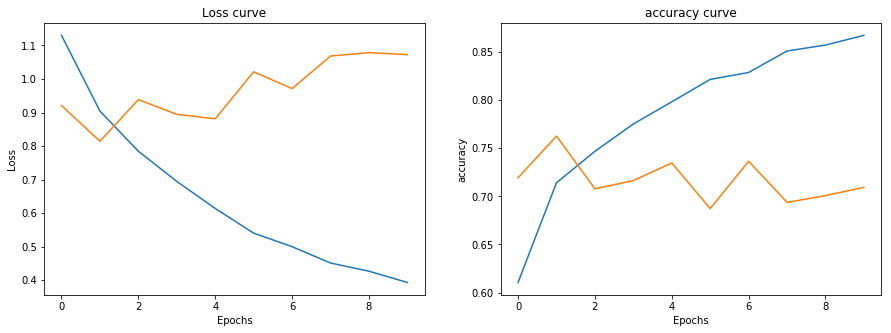

In [1513]:
#plot training curve
training_plot()

# Summary

In this work, in order to building a more predictive system, couple things were done:
1. customer segmentation: by comparing customer behavior such as recency, frequency and monetory_value, the customers are divided into three clusters: loyal, medium active and lowest active. 
2. feature engineering: by aggregating features based on customers' recent order or browsing behavior, 6 aggregated features are created. And most of these features are proved to be very predictive.
3. compare models: three traditional ML models (random forest, GBDT and Catboost) are compared with neural network model with embedding layer. By comparison, Catboost achieved the highest accuracy value (avg 0.84). Neural network has the lowest val_accuracy value (avg 0.75) with 10 epoch of training.

Improvements to be done:
1. In the current feature engineering section, only 6 features were created due to limited time. More aggregated features can be added, such as customers' order or online behavior in the past 3/30/90 days, etc. 
2. PCA can also be used to generate some extracted features to increase the predictive power.
3. For the neural network model:
        a. Normalize the input data to reduce influence of data skewness 
        b. Finetune model architechture
        c. Feature eningeering to reduce variance or overfitting.
4. Currently, I picked one (loyal customer) cluster. In the future, this clusterid (0,1,2) can also be treated as a feature for the whole dataset. In that way, we can make just one model for all the customers.